In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [2]:
def latest_version(cat):#this function gets the latest version of our catalog
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal subset','model','mip_table',
                                               'institute','variable','ensemble_member',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat


In [3]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [4]:
model_name = 'GFDL-ESM4'

In [5]:
#mlotst, tos,uo,vo

In [6]:
#tos_ sea surface temperature
#area cello
#ofx ocean fixed
#omon  ocean monthly average 

In [7]:

query_Omon_tos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model= model_name,
                 grid_label=['gn'],
                 variable=["tos"])
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Ofx'],
                 #ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model= model_name,
                 grid_label=['gn'],
                 variable=["areacello"])

In [8]:
cat_Omon_tos = col.search(**query_Omon_tos)
cat_Omon_tos_lat = latest_version(cat_Omon_tos)

cat_Omon_tos_latest = intake.open_esm_datastore(cat_Omon_tos_lat,esmcol_data=esmcol_data)

In [9]:
cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx)

cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [10]:
dict_Omon_tos = cat_Omon_tos_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {'time': 1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [11]:
dict_Ofx = cat_Ofx_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [12]:
dict_Omon_tos.keys()

dict_keys(['CMIP6.NOAA-GFDL.GFDL-ESM4.1pctCO2.Omon', 'CMIP6.NOAA-GFDL.GFDL-ESM4.abrupt-4xCO2.Omon', 'CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon'])

In [13]:
ds_hist = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon"]
ds_hist

<xarray.Dataset>
Dimensions:          (bnds: 2, ensemble_member: 1, time: 1980, vertex: 4, x: 720, y: 576)
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * bnds             (bnds) float64 1.0 2.0
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: vertex
Data variables:
    lat_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    time_bnds        (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    tos              (ensemble_member, time, y, x) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
Attributes: (12/48)
    table_id:                Omon
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    realization_index:       [1]
    branch_time_in_parent:   [36500.]
    initialization_index:    [1]
    frequency:               mon
    ...                      ...
    sub_experiment:          none
    parent_time_units:       days since 0001-1-1
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    history:                 File was processed by fremetar (GFDL analog of C...
    parent_experiment_id:    piControl
    intake_esm_dataset_key:  CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon

In [14]:
ds_Ofx = dict_Ofx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

In [15]:
ds_Ofx

<xarray.Dataset>
Dimensions:          (ensemble_member: 1, vertex: 4, x: 720, y: 576)
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: vertex
Data variables:
    areacello        (ensemble_member, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    lat_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
Attributes: (12/47)
    title:                   NOAA GFDL GFDL-ESM4 model output prepared for CM...
    history:                 File was processed by fremetar (GFDL analog of C...
    table_id:                Ofx
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    [0.]
    ...                      ...
    variable_id:             areacello
    variant_info:            N/A
    references:              see further_info_url attribute
    variant_label:           r1i1p1f1
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx

In [16]:
ds_hist.tos.lon

<xarray.DataArray 'lon' (y: 576, x: 720)>
dask.array<open_dataset-b85cebac4b99854c6d2790d458b00a2dlon, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * x        (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.25 58.75 59.25 59.75
  * y        (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.26 89.47 89.68 89.89
Attributes:
    long_name:      longitude
    units:          degrees_east
    cell_methods:   y: point x: point
    standard_name:  longitude
    bounds:         lon_bnds

In [17]:
ds_hist.tos.sel(y = [-5,5], x = [-150, -90], method="nearest")#.to_dataframe()

<xarray.DataArray 'tos' (ensemble_member: 1, time: 1980, y: 2, x: 2)>
dask.array<getitem, shape=(1, 1980, 2, 2), dtype=float32, chunksize=(1, 1, 2, 2), chunktype=numpy.ndarray>
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(2, 2), meta=np.ndarray>
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x                (x) float64 -149.8 -89.75
  * y                (y) float64 -4.872 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    standard_name:  sea_surface_temperature
    original_name:  tos

NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

In [18]:
tos = ds_hist.tos.sel(time = slice("1980", "2011"))

In [19]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos = ds_hist.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

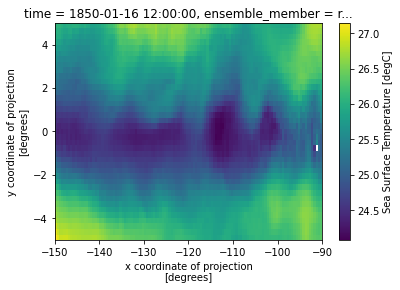

In [20]:
tos.isel(time=0).plot()

In [21]:
#TODO INSERT CELL SELECT region of interest in areacello
areacello_nino3 = ds_Ofx.areacello.sel(y = slice(-5,5), x = slice(-150,-90))

In [22]:
#areacello_nino3.isel(time=0).plot()

In [23]:
#TODO 
#CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino3.sum(dim=('x', 'y'))


CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [24]:
tos_mean_nino3 = (tos * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [27]:
tos_mean_nino3.compute()

<xarray.DataArray (ensemble_member: 1, time: 1980)>
array([[25.484543, 25.101374, 25.64276 , ..., 23.6965  , 23.806202,
        24.474295]], dtype=float32)
Coordinates:
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [28]:
tos_mean_nino3.size #1980 values, 1 value per month , 12 per year for 165 years

1980

In [29]:
tos_mean_nino3.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.484543], dtype=float32)
Coordinates:
    time             object 1850-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [30]:
datetimeindex = tos_mean_nino3.indexes['time'].to_datetimeindex()
tos_mean_nino3['time'] = datetimeindex


<ipython-input-30-e3bd8c937fe9>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = tos_mean_nino3.indexes['time'].to_datetimeindex()


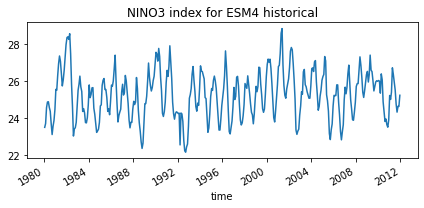

In [31]:
tos_mean_nino3.sel(time=slice('1980','2011')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 historical")
plt.tight_layout()
plt.draw()

ADDITIONAL EXPLORATION

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [33]:
tos_nino3_climatology = tos.sel(time=slice('1950','1951')).groupby('time.month').mean(dim='time')


In [34]:
tos_nino3_climatology.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, month: 12, y: 39, x: 120)>
array([[[[27.57766 , 27.537079, 27.492886, ..., 26.933033, 26.940826,
          26.952969],
         [27.44797 , 27.401659, 27.331524, ..., 26.857271, 26.882162,
          26.909405],
         [27.299244, 27.188475, 27.137547, ..., 26.768753, 26.793587,
          26.831043],
         ...,
         [26.707531, 26.70523 , 26.711327, ..., 27.195108, 27.249273,
          27.285545],
         [26.765951, 26.77192 , 26.784273, ..., 27.201971, 27.281311,
          27.322285],
         [26.798332, 26.79142 , 26.864128, ..., 27.205044, 27.291027,
          27.349037]],

        [[27.771057, 27.75226 , 27.744286, ..., 28.078775, 27.99737 ,
          27.957499],
         [27.638443, 27.611866, 27.598177, ..., 27.933655, 27.863216,
          27.842106],
         [27.451347, 27.424408, 27.441511, ..., 27.763546, 27.710487,
          27.719225],
...
         [26.492563, 26.470863, 26.392384, ..., 27.068047, 27.03642 ,
          26.986437],
         [26.626316, 26.630398, 26.567574, ..., 27.193192, 27.130432,
          27.046753],
         [26.822187, 26.803291, 26.735695, ..., 27.251354, 27.196472,
          27.120453]],

        [[26.645472, 26.604963, 26.537882, ..., 24.118637, 24.107162,
          24.092106],
         [26.564085, 26.513676, 26.445034, ..., 24.065739, 24.060478,
          24.052505],
         [26.494349, 26.437841, 26.362827, ..., 24.01078 , 24.004425,
          24.001783],
         ...,
         [26.078804, 26.08772 , 26.096737, ..., 26.431509, 26.470829,
          26.548588],
         [26.196327, 26.227783, 26.229935, ..., 26.371914, 26.428902,
          26.536629],
         [26.337807, 26.305786, 26.277866, ..., 26.269876, 26.357975,
          26.499115]]]], dtype=float32)
Coordinates:
    lat              (y, x) float32 -4.872 -4.872 -4.872 ... 4.872 4.872 4.872
    lon              (y, x) float32 -149.8 -149.2 -148.8 ... -90.75 -90.25
  * x                (x) float64 -149.8 -149.2 -148.8 ... -91.25 -90.75 -90.25
  * y                (y) float64 -4.872 -4.615 -4.359 ... 4.359 4.615 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

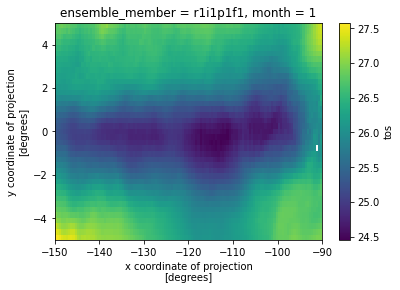

In [35]:
tos_nino3_climatology.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [36]:
tos_sel = tos.sel(time=slice('1950','1951'))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [37]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, time: 24)>
array([[ 0.10937247,  0.66076964,  0.6788649 ,  0.9604627 ,  1.17484   ,
         0.98832625,  0.2764574 ,  0.5828009 ,  0.27212954,  0.62230104,
         0.4373594 ,  0.45037058, -0.10937243, -0.6607696 , -0.6788649 ,
        -0.9604627 , -1.17484   , -0.98832613, -0.2764574 , -0.58280087,
        -0.27212957, -0.62230104, -0.43735942, -0.45037064]],
      dtype=float32)
Coordinates:
  * time             (time) object 1950-01-16 12:00:00 ... 1951-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12

<ipython-input-38-90fd70a17ab6>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = index_nino3.indexes['time'].to_datetimeindex()


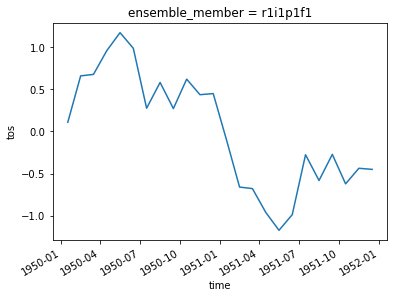

In [38]:
datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
index_nino3['time'] = datetimeindex
index_nino3.plot()

Just to document the requests, apart from the current set of fields  (i.e., Omon/tauuo, Omon/tauvo, deptho/Ofx, Omon/zos) we use for our present work, we will further need: mlotst, tos,uo,vo from Omon -- all on the ocean native grid. We also need pr from Amon. TOS will be used to calculate the NINO3 index (5S-5N , 150W-90W). 

In [ ]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)

In [ ]:
#Examples to just search for what we want from the catalog
expname_filter = ['1pctCO2']
table_id_filter = 'Omon'
model_filter = 'IPSL-CM6A-LR'
#variable_id_filter = "zos"
grid_label_filter = 'gn'
ens_filter = "r1i1p1f1"
#version_filter = "v20190726"

col_mlost_Hist = col.search(#experiment_id=expname_filter,
                 mip_table=table_id_filter,
                 model=model_filter,
                 variable=['mlotst'],
                 grid_label=grid_label_filter,
                 ensemble_member = ens_filter
                )

col_tos_Hist = col.search(#experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['tos'],
                       ensemble_member = ens_filter
                       )

col_uo_Hist = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['uo'],
                       ensemble_member = ens_filter
                       )

col_vo_Hist = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['vo'],
                       ensemble_member = ens_filter
                       )

In [ ]:
col_mlost_Hist.df

In [ ]:
col_tos_Hist.df

In [ ]:
col_uo_Hist.df

In [ ]:
col_vo_Hist.df